In [105]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

from sklearn import datasets 
from sklearn.feature_selection import RFE 
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer

# Part 1: Data Preprocessing

# Read In Data and Restructure

In [135]:
# read fire data
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
df = pd.read_sql_query("SELECT FIRE_YEAR, STAT_CAUSE_DESCR, LATITUDE, LONGITUDE, STATE, COUNTY, FIPS_NAME, DISCOVERY_DATE, CONT_DATE, FIRE_SIZE, DISCOVERY_DOY, DISCOVERY_TIME FROM 'Fires'", conn)
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['END_DATE'] = pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
print(df.head())

FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE COUNTY  FIPS_NAME  \
0       2005    Miscellaneous  40.036944 -121.005833    CA     63     Plumas   
1       2004        Lightning  38.933056 -120.404444    CA     61     Placer   
2       2004   Debris Burning  38.984167 -120.735556    CA     17  El Dorado   
3       2004        Lightning  38.559167 -119.913333    CA      3     Alpine   
4       2004        Lightning  38.559167 -119.933056    CA      3     Alpine   

   DISCOVERY_DATE  CONT_DATE  FIRE_SIZE  DISCOVERY_DOY DISCOVERY_TIME  \
0       2453403.5  2453403.5       0.10             33           1300   
1       2453137.5  2453137.5       0.25            133           0845   
2       2453156.5  2453156.5       0.10            152           1921   
3       2453184.5  2453189.5       0.10            180           1600   
4       2453184.5  2453189.5       0.10            180           1600   

        DATE   END_DATE  
0 2005-02-02 2005-02-02  
1 2004-05-12 2004-05-12  
2 200

In [136]:
# Extract and reformat DATETIME for easy lookup for fire data
df['TIME'] = df['DISCOVERY_TIME'].str[0:2]
df['DATETIME'] = df['DATE'].dt.strftime('%Y-%m-%d') + ' ' +  df['TIME']
print(df)

FIRE_YEAR   STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE COUNTY  \
0             2005      Miscellaneous  40.036944 -121.005833    CA     63   
1             2004          Lightning  38.933056 -120.404444    CA     61   
2             2004     Debris Burning  38.984167 -120.735556    CA     17   
3             2004          Lightning  38.559167 -119.913333    CA      3   
4             2004          Lightning  38.559167 -119.933056    CA      3   
...            ...                ...        ...         ...   ...    ...   
1880460       2015  Missing/Undefined  40.481637 -122.389375    CA   None   
1880461       2015      Miscellaneous  37.617619 -120.938570    CA   None   
1880462       2015  Missing/Undefined  37.617619 -120.938570    CA   None   
1880463       2015  Missing/Undefined  37.672235 -120.898356    CA   None   
1880464       2015      Miscellaneous  34.263217 -116.830950    CA   None   

         FIPS_NAME  DISCOVERY_DATE  CONT_DATE  FIRE_SIZE  DISCOVERY_DOY  \
0        

In [137]:
# Prune years not in range 2012-2015 for fire data
df = df[df['FIRE_YEAR'] >= 2012]
print(df)

FIRE_YEAR   STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE COUNTY  \
1563819       2012           Campfire  45.991944 -113.471389    MT    039   
1563820       2012           Campfire  45.946667 -112.366111    MT    043   
1563821       2012           Campfire  45.418611 -111.855833    MT    057   
1563822       2012           Campfire  46.219167 -112.243333    MT    093   
1563823       2012          Lightning  44.942222 -113.458611    MT    001   
...            ...                ...        ...         ...   ...    ...   
1880460       2015  Missing/Undefined  40.481637 -122.389375    CA   None   
1880461       2015      Miscellaneous  37.617619 -120.938570    CA   None   
1880462       2015  Missing/Undefined  37.617619 -120.938570    CA   None   
1880463       2015  Missing/Undefined  37.672235 -120.898356    CA   None   
1880464       2015      Miscellaneous  34.263217 -116.830950    CA   None   

          FIPS_NAME  DISCOVERY_DATE  CONT_DATE  FIRE_SIZE  DISCOVERY_DOY  \
1563819 

In [138]:
# Read in Weather Data
# df_fire = pd.read_csv('California_Fire_Incidents.csv')
df_humidity = pd.read_csv('humidity.csv')
df_pressure = pd.read_csv('pressure.csv')
df_temp = pd.read_csv('temperature.csv')
df_weather = pd.read_csv('weather_description.csv')
df_wind_direction = pd.read_csv('wind_direction.csv')
df_wind_speed = pd.read_csv('wind_speed.csv')
df_city_attributes = pd.read_csv('city_attributes.csv')

In [139]:
# Prune Irrelevant Cities
cities = df_humidity.columns.drop(['Jerusalem', 'Haifa', 'Eilat', 'Tel Aviv District', 'Beersheba', 'Nahariyya'])
df_humidity = df_humidity[cities]
df_pressure = df_pressure[cities]
df_temp = df_temp[cities]
df_weather = df_weather[cities]
df_wind_direction = df_wind_direction[cities]
df_wind_speed = df_wind_speed[cities]
# df_city_attributes = df_city_attributes[cities]

In [140]:
# Find all cities common between forest fire data and weather data
common_cities = []
for city in cities:
    if(len(df.loc[df['FIPS_NAME']==city]) != 0):
        common_cities.append(city)

In [141]:
# Prune all cities not common between forest fire data and weather data
df = df[df['FIPS_NAME'].isin(common_cities)]
print(df)

FIRE_YEAR   STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  \
1567432       2012      Miscellaneous  34.204167 -117.808333    CA   
1567433       2012          Lightning  34.345278 -117.928889    CA   
1567434       2012      Miscellaneous  34.548056 -118.671667    CA   
1567436       2012      Equipment Use  34.489444 -118.285833    CA   
1567437       2012           Children  34.467778 -118.530833    CA   
...            ...                ...        ...         ...   ...   
1872185       2015  Missing/Undefined  33.387140 -117.174866    CA   
1872229       2015     Debris Burning  33.226976 -117.024311    CA   
1872237       2015  Missing/Undefined  34.666666 -118.766666    CA   
1872244       2015  Missing/Undefined  33.388859 -117.255707    CA   
1872247       2015     Debris Burning  33.243255 -117.241177    CA   

              COUNTY    FIPS_NAME  DISCOVERY_DATE  CONT_DATE  FIRE_SIZE  \
1567432          037  Los Angeles       2456104.5  2456104.5       0.10   
1567433          0

In [142]:
# Combine and Restructure all weather dataframes into one DataFrame and append a city column
columns = ['time', 'humidity', 'pressure', 'temperature', 'weather', 'wind direction', 'wind speed']
df_weatherdata = pd.DataFrame()
for city in common_cities:
    newdf = pd.DataFrame(pd.concat([df_humidity['datetime'], df_humidity[city], df_pressure[city], df_temp[city], df_weather[city], df_wind_direction[city], df_wind_speed[city]], axis=1, keys=columns))
    newdf['city'] = city
    df_weatherdata = df_weatherdata.append(newdf, ignore_index=True)
print(df_weatherdata)

time  humidity  pressure  temperature       weather  \
0       2012-10-01 13:00:00      88.0    1009.0   289.480000    light rain   
1       2012-10-01 14:00:00      87.0    1009.0   289.474993  sky is clear   
2       2012-10-01 15:00:00      86.0    1009.0   289.460618  sky is clear   
3       2012-10-01 16:00:00      85.0    1009.0   289.446243  sky is clear   
4       2012-10-01 17:00:00      84.0    1009.0   289.431869  sky is clear   
...                     ...       ...       ...          ...           ...   
362011  2017-11-29 20:00:00       NaN       NaN          NaN           NaN   
362012  2017-11-29 21:00:00       NaN       NaN          NaN           NaN   
362013  2017-11-29 22:00:00       NaN       NaN          NaN           NaN   
362014  2017-11-29 23:00:00       NaN       NaN          NaN           NaN   
362015  2017-11-30 00:00:00       NaN       NaN          NaN           NaN   

        wind direction  wind speed           city  
0                150.0         2.0

In [143]:
# Combine Date and Time for Easy Lookup
df_weatherdata['DATE'] = df_weatherdata['time'].str[0:11]
df_weatherdata['TIME'] = df_weatherdata['time'].str.split(":").str[0].str[11:]
df_weatherdata['DATETIME'] = df_weatherdata['DATE'] + df_weatherdata['TIME']
print(df_weatherdata['DATETIME'])

0         2012-10-01 13
1         2012-10-01 14
2         2012-10-01 15
3         2012-10-01 16
4         2012-10-01 17
              ...      
362011    2017-11-29 20
362012    2017-11-29 21
362013    2017-11-29 22
362014    2017-11-29 23
362015    2017-11-30 00
Name: DATETIME, Length: 362016, dtype: object


In [144]:
# Prune years that arent between 2012-2015
df_weatherdata = df_weatherdata[~(df_weatherdata['DATE'].astype(str).str.contains('2016') | df_weatherdata['DATE'].astype(str).str.contains('2017'))]
print(df_weatherdata['DATE'])

0         2012-10-01 
1         2012-10-01 
2         2012-10-01 
3         2012-10-01 
4         2012-10-01 
             ...     
345234    2015-12-31 
345235    2015-12-31 
345236    2015-12-31 
345237    2015-12-31 
345238    2015-12-31 
Name: DATE, Length: 227800, dtype: object


In [145]:
# Combine DATETIME and Cities for easy lookup for weather data
df_weatherdata['DATETIME_CITY'] = df_weatherdata['DATETIME'] + ' ' + df_weatherdata['city']
print(df_weatherdata['DATETIME_CITY'])

0         2012-10-01 13 San Francisco
1         2012-10-01 14 San Francisco
2         2012-10-01 15 San Francisco
3         2012-10-01 16 San Francisco
4         2012-10-01 17 San Francisco
                     ...             
345234         2015-12-31 19 New York
345235         2015-12-31 20 New York
345236         2015-12-31 21 New York
345237         2015-12-31 22 New York
345238         2015-12-31 23 New York
Name: DATETIME_CITY, Length: 227800, dtype: object


In [146]:
# Combine DATETIME and Cities for easy lookup for forest fire data
df['DATETIME_CITY'] = df['DATETIME'].astype(str) + ' ' + df['FIPS_NAME']
print(df['DATETIME_CITY'])

1567432    2012-06-26 10 Los Angeles
1567433    2012-09-10 10 Los Angeles
1567434    2012-11-05 13 Los Angeles
1567436    2012-06-28 10 Los Angeles
1567437    2012-06-21 18 Los Angeles
                     ...            
1872185      2015-11-28 15 San Diego
1872229      2015-12-29 17 San Diego
1872237    2015-11-04 14 Los Angeles
1872244      2015-10-13 03 San Diego
1872247      2015-12-09 16 San Diego
Name: DATETIME_CITY, Length: 3722, dtype: object


In [147]:
df_weatherdata['FIRE_DAYS'] = False

In [148]:
# Create a Fire column to track which datetimes in which cities had fires occur
df_weatherdata['FIRE'] = False
df_weatherdata['FIRE'][df_weatherdata.loc[df_weatherdata['DATETIME_CITY'].isin(df['DATETIME_CITY'].values)].index] = True
df_weatherdata = df_weatherdata[df_weatherdata.columns.drop(['time', 'DATE', 'TIME', 'DATETIME_CITY'])]
# print(df_weatherdata.loc[df_weatherdata['FIRE']==True])

In [149]:
df_weatherdata

,humidity,pressure,temperature,weather,wind direction,wind speed,city,DATETIME,FIRE_DAYS,FIRE
0,88.0,1009.0,289.480000,light rain,150.0,2.0,San Francisco,2012-10-01 13,False,False
1,87.0,1009.0,289.474993,sky is clear,147.0,2.0,San Francisco,2012-10-01 14,False,False
2,86.0,1009.0,289.460618,sky is clear,141.0,2.0,San Francisco,2012-10-01 15,False,False
3,85.0,1009.0,289.446243,sky is clear,135.0,2.0,San Francisco,2012-10-01 16,False,False
4,84.0,1009.0,289.431869,sky is clear,129.0,2.0,San Francisco,2012-10-01 17,False,False
...,...,...,...,...,...,...,...,...,...,...
345234,66.0,1017.0,281.210000,overcast clouds,290.0,6.0,New York,2015-12-31 19,False,False
345235,66.0,1017.0,281.220000,overcast clouds,310.0,5.0,New York,2015-12-31 20,False,False
345236,64.0,1017.0,281.026831,overcast clouds,307.0,5.0,New York,2015-12-31 21,False,False
345237,61.0,1018.0,280.360000,overcast clouds,300.0,5.0,New York,2015-12-31 22,False,False


In [150]:
# before continuing drop any row that contains NaN values in more than one column
df_weatherdata.dropna(subset=['humidity', 'pressure', 'temperature'], how='all', inplace=True)
df_weatherdata.shape

(227800, 10)

In [151]:
# Want to get rid of DATETIME, FIRE_DAYS, and FIRE for now
df_holder = pd.concat([df_weatherdata.pop(x) for x in ['DATETIME', 'FIRE_DAYS', 'FIRE']], axis=1)

# Encoding Features

In [152]:
# Start Label Encoding weather and city
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_weatherdata['weather'] = le.fit_transform(df_weatherdata['weather'].astype(str))
df_weatherdata['city'] = le.fit_transform(df_weatherdata['city'].astype(str))

In [153]:
# Function to assist with Imputing
from sklearn.experimental import enable_iterative_imputer # required to use IterativeImputer
from sklearn.impute import IterativeImputer # filling nan

# function that will fill in the NaN values using MICE imputation method
def mvImp(df_incomplete):
    # fill the na values with 9999
    df_incomplete = df_incomplete.fillna(9999)
    # create an object of type IterativeImputer from the sklearn class
    imputer = IterativeImputer(missing_values = 9999, max_iter=30, random_state=0,
                 add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean', 
                 max_value=None, min_value=None, 
                 n_nearest_features=None,
                 tol=0.001, verbose=0)
    # fit the object on our incomplete data
    imputer.fit(df_incomplete)
    # transform the data and store into a new variable
    imputedData = imputer.transform(df_incomplete)

    return imputedData

In [154]:
# Impute NaN values in df_weatherdata
df_weatherdata = mvImp(df_weatherdata)

In [155]:
# Convert df_weather data back into pandas dataframe
df_weatherdata = pd.DataFrame(df_weatherdata,columns=['humidity', 'pressure', 'temperature', 'weather', 
                                                      'wind direction', 'wind speed', 'city'])

In [156]:
df_weatherdata = pd.concat([df_weatherdata.reset_index(drop=True),df_holder.reset_index(drop=True)], axis=1)

In [163]:
df_weatherdata['HOUR'] = df_weatherdata['DATETIME'].str[11:]
df_weatherdata['DAY'] = df_weatherdata['DATETIME'].str[8:10]
df_weatherdata['MONTH'] = df_weatherdata['DATETIME'].str[5:7]
df_weatherdata['YEAR'] = df_weatherdata['DATETIME'].str[0:4]

# Can drop the DATETIME column as we are encoding it in a way to get more information
del df_weatherdata['DATETIME']

In [164]:
df_weatherdata

,humidity,pressure,temperature,weather,wind direction,wind speed,city,FIRE_DAYS,FIRE,HOUR,DAY,MONTH,YEAR,HOUR_SIN,HOUR_COS,DAY_SIN,DAY_COS,MONTH_SIN,MONTH_COS
0,88.0,1009.0,289.480000,12.0,150.0,2.0,7.0,False,False,13,01,10,2012,-0.258819,-0.965926,0.207912,0.978148,-8.660254e-01,0.5
1,87.0,1009.0,289.474993,24.0,147.0,2.0,7.0,False,False,14,01,10,2012,-0.500000,-0.866025,0.207912,0.978148,-8.660254e-01,0.5
2,86.0,1009.0,289.460618,24.0,141.0,2.0,7.0,False,False,15,01,10,2012,-0.707107,-0.707107,0.207912,0.978148,-8.660254e-01,0.5
3,85.0,1009.0,289.446243,24.0,135.0,2.0,7.0,False,False,16,01,10,2012,-0.866025,-0.500000,0.207912,0.978148,-8.660254e-01,0.5
4,84.0,1009.0,289.431869,24.0,129.0,2.0,7.0,False,False,17,01,10,2012,-0.965926,-0.258819,0.207912,0.978148,-8.660254e-01,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227795,66.0,1017.0,281.210000,17.0,290.0,6.0,5.0,False,False,19,31,12,2015,-0.965926,0.258819,0.207912,0.978148,-2.449294e-16,1.0
227796,66.0,1017.0,281.220000,17.0,310.0,5.0,5.0,False,False,20,31,12,2015,-0.866025,0.500000,0.207912,0.978148,-2.449294e-16,1.0
227797,64.0,1017.0,281.026831,17.0,307.0,5.0,5.0,False,False,21,31,12,2015,-0.707107,0.707107,0.207912,0.978148,-2.449294e-16,1.0
227798,61.0,1018.0,280.360000,17.0,300.0,5.0,5.0,False,False,22,31,12,2015,-0.500000,0.866025,0.207912,0.978148,-2.449294e-16,1.0


In [165]:
# Encode DATETIME in a way that preserves its cyclical nature
df_weatherdata['HOUR_SIN'] = np.sin(df_weatherdata['HOUR'].astype(float)*(2.*np.pi/24))
df_weatherdata['HOUR_COS'] = np.cos(df_weatherdata['HOUR'].astype(float)*(2.*np.pi/24))
df_weatherdata['DAY_SIN'] = np.sin(df_weatherdata['DAY'].astype(float)*(2.*np.pi/30))
df_weatherdata['DAY_COS'] = np.cos(df_weatherdata['DAY'].astype(float)*(2.*np.pi/30))
df_weatherdata['MONTH_SIN'] = np.sin(df_weatherdata['MONTH'].astype(float)*(2.*np.pi/12))
df_weatherdata['MONTH_COS'] = np.cos(df_weatherdata['MONTH'].astype(float)*(2.*np.pi/12))

In [166]:
df_weatherdata.columns

Index(['humidity', 'pressure', 'temperature', 'weather', 'wind direction',
       'wind speed', 'city', 'FIRE_DAYS', 'FIRE', 'HOUR', 'DAY', 'MONTH',
       'YEAR', 'HOUR_SIN', 'HOUR_COS', 'DAY_SIN', 'DAY_COS', 'MONTH_SIN',
       'MONTH_COS'],
      dtype='object')

# Part 2: Feature Analysis

In [167]:
# Feature Importance functions

from sklearn.ensemble import RandomForestRegressor # feature importance

# Function for Random Forest Feature Importance
def rf_feature_importance(dataFrame):
    names = dataFrame.columns
    df_copy = dataFrame.copy()
    Y = df_copy.pop('FIRE')
    X = df_copy
    
    rf = RandomForestRegressor()
    rf.fit(X, Y)
    
    print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
    
# Function to calculate Pearson correlation heatmap
def pearson_feature_importance(dataFrame, threshold):
    plt.figure(figsize=(12,10))
    cor = dataFrame.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()
    
    cor_target = abs(cor['FIRE'])
    relevant_features = cor_target[cor_target > threshold]
    print(relevant_features)

In [168]:
# Random Forest
rf_feature_importance(df_weatherdata)

[(0.2196, 'temperature'), (0.1293, 'wind direction'), (0.113, 'humidity'), (0.0867, 'pressure'), (0.0498, 'HOUR'), (0.049, 'HOUR_COS'), (0.0474, 'DAY_SIN'), (0.0415, 'weather'), (0.0399, 'FIRE'), (0.0396, 'HOUR_SIN'), (0.0392, 'wind speed'), (0.0355, 'YEAR'), (0.0248, 'DAY_COS'), (0.0219, 'city'), (0.0213, 'MONTH_SIN'), (0.0213, 'DAY'), (0.0202, 'MONTH'), (0.0, 'FIRE_DAYS')]


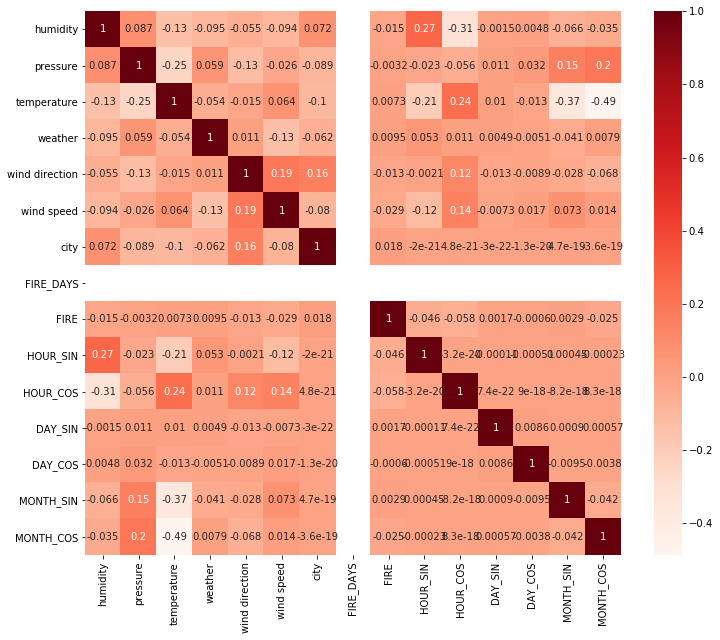

FIRE    1.0
Name: FIRE, dtype: float64


In [169]:
# Pearson Correlation
pearson_feature_importance(df_weatherdata, threshold=0.2)

# PART 3: DataSet Preprocessing

In [171]:
X = df_weatherdata[df_weatherdata.columns.drop(['FIRE', 'FIRE_DAYS'])]
y = df_weatherdata['FIRE']

In [172]:
# Easier to label encode y from here
y = le.fit_transform(y)

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [174]:
X_train

,humidity,pressure,temperature,weather,wind direction,wind speed,city,HOUR,DAY,MONTH,YEAR,HOUR_SIN,HOUR_COS,DAY_SIN,DAY_COS,MONTH_SIN,MONTH_COS
99103,77.0,1008.0,292.910000,17.0,170.0,6.0,1.0,11,24,04,2014,0.258819,-9.659258e-01,-9.510565e-01,0.309017,8.660254e-01,-5.000000e-01
90523,45.0,1007.0,300.830000,3.0,140.0,7.0,1.0,23,01,05,2013,-0.258819,9.659258e-01,2.079117e-01,0.978148,5.000000e-01,-8.660254e-01
188038,81.0,1027.0,303.429333,24.0,218.0,3.0,4.0,17,17,09,2014,-0.965926,-2.588190e-01,-4.067366e-01,-0.913545,-1.000000e+00,-1.836970e-16
199474,50.0,1007.0,297.400000,0.0,250.0,5.0,5.0,18,07,10,2012,-1.000000,-1.836970e-16,9.945219e-01,0.104528,-8.660254e-01,5.000000e-01
58379,72.0,1023.0,288.200000,0.0,0.0,0.0,6.0,02,30,11,2012,0.500000,8.660254e-01,-2.449294e-16,1.000000,-5.000000e-01,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,65.0,1013.0,304.310000,24.0,84.0,0.0,2.0,16,07,06,2013,-0.866025,-5.000000e-01,9.945219e-01,0.104528,1.224647e-16,-1.000000e+00
103694,55.0,1043.0,284.482000,24.0,110.0,4.0,1.0,18,01,11,2014,-1.000000,-1.836970e-16,2.079117e-01,0.978148,-5.000000e-01,8.660254e-01
131932,46.0,1031.0,299.098500,24.0,77.0,3.0,2.0,21,22,10,2014,-0.707107,7.071068e-01,-9.945219e-01,-0.104528,-8.660254e-01,5.000000e-01
146867,66.0,1016.0,286.700000,17.0,340.0,4.0,0.0,17,06,04,2013,-0.965926,-2.588190e-01,9.510565e-01,0.309017,8.660254e-01,-5.000000e-01


# Standardize

In [206]:
# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [207]:
X_train

array([[ 0.33599853, -1.36452165,  0.28250528, ...,  0.41439979,
         1.30456295, -0.78228429],
       [-1.30316738, -1.47691587,  1.20354232, ...,  1.35560703,
         0.77804012, -1.29405949],
       [ 0.54089427,  0.77096851,  1.50582544, ..., -1.30527141,
        -1.37969058, -0.08318637],
       ...,
       [-1.25194345,  1.22054539,  1.00218176, ..., -0.16729827,
        -1.18696984,  0.61591156],
       [-0.22746475, -0.4653679 , -0.4396715 , ...,  0.41439979,
         1.30456295, -0.78228429],
       [ 0.4384464 , -1.13973321,  1.00584497, ...,  1.26473687,
        -1.37969058, -0.08318637]])

# Resampling 

In [208]:
from imblearn.over_sampling import SMOTE, ADASYN

# Smote for resampling
X_oversampled, y_oversampled = SMOTE().fit_sample(X_train, y_train)

In [209]:
pd.crosstab(index=y_oversampled, columns='count')

col_0,count
row_0,
0,151397
1,151397


In [210]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_undersampled , y_undersampled = rus.fit_resample(X_train, y_train)

In [211]:
pd.crosstab(index=y_undersampled, columns='count')

col_0,count
row_0,
0,1229
1,1229


# Part 4 Model Training

## Logistic Regression

In [212]:
def fiveCVLogisticRegression(xtrain, ytrain, C_grid):
    scores_train = np.zeros(len(C_grid))
    scores_test = np.zeros(len(C_grid))
    for i in range(5):
        print('Run ', i+1)
        kfold = StratifiedKFold(n_splits=5, shuffle=True)
        
        model = LogisticRegression(penalty='l2')

        grid={"C":C_grid, "penalty":["l2"]} # l2 ridge
        logreg=LogisticRegression()
        logreg_cv=GridSearchCV(logreg,grid,cv=kfold,return_train_score=True)
        logreg_cv.fit(xtrain, ytrain)

        # View the accuracy score
        # print('Best score for training data:', logreg_cv.best_score_,"\n") 

        # View the best parameters for the model found using grid search
        print('Best lambda:',1.0/logreg_cv.best_estimator_.C,"\n") 


        # print("Training set score for logreg_cv: ",  logreg_cv.cv_results_['mean_train_score'])
        # print("Testing  set score for logreg_cv: ", logreg_cv.cv_results_['mean_test_score'])

        scores_train += logreg_cv.cv_results_['mean_train_score']
        scores_test += logreg_cv.cv_results_['mean_test_score']

    scores_train = scores_train/5
    scores_test = scores_test/5
   

    print('avg train score: ', scores_train)
    print('avg test score: ', scores_test)
    return scores_train, scores_test

In [213]:
C_grid = [1e-3, 1e-2, 1e-1, 1, 1e1, 50.0, 1e2, 1e3]
scores_train_std, scores_test_std = fiveCVLogisticRegression(X_oversampled, y_oversampled, C_grid)

Run  1
Best lambda: 0.1 

Run  2
Best lambda: 10.0 

Run  3
Best lambda: 10.0 

Run  4
Best lambda: 10.0 

Run  5
Best lambda: 100.0 

avg train score:  [0.7413963  0.74145013 0.74146978 0.74146945 0.74146862 0.74146879
 0.74146879 0.74146879]
avg test score:  [0.74138061 0.74148431 0.74149289 0.74148893 0.74148959 0.74149025
 0.74149025 0.74149025]


In [214]:
C_grid = [1e-3, 1e-2, 1e-1, 1, 1e1, 50.0, 1e2, 1e3]
scores_train_std, scores_test_std = fiveCVLogisticRegression(X_undersampled, y_undersampled, C_grid)

Run  1
Best lambda: 100.0 

Run  2
Best lambda: 100.0 

Run  3
Best lambda: 0.1 

Run  4
Best lambda: 10.0 

Run  5
Best lambda: 10.0 

avg train score:  [0.72270176 0.73199763 0.73246535 0.73266878 0.73264843 0.73268911
 0.73268911 0.73268911]
avg test score:  [0.71725266 0.7273386  0.72782574 0.72701306 0.72701306 0.72701306
 0.72701306 0.72701306]


In [184]:
def CVLogisticRegression(xtrain, ytrain, xtest, ytest, _lambda):
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    model = LogisticRegression(penalty='l2', C=1/_lambda)
    model.fit(xtrain, ytrain)

    train_score = 1 - model.score(xtrain, ytrain)
    test_score = 1 - model.score(xtest, ytest)


    return train_score, test_score

In [215]:
avg_train_error_oversampled, avg_test_error_oversampled = CVLogisticRegression(X_oversampled, y_oversampled, X_test, y_test, 10)

In [216]:
avg_train_error_undersampled, avg_test_error_undersampled = CVLogisticRegression(X_undersampled, y_undersampled, X_test, y_test, 0.1)

In [217]:
table = {'Method': ['Logistic Regression'], 
        #  'lambda': [best_lambda_std, best_lambda_log, best_lambda_bin], 
        #  'Avg Val Error': [avg_val_error_std, avg_val_error_log, avg_val_error_bin], 
         'Train Error (oversampled) 1': [avg_train_error_oversampled], 
         'Train Error (oversampled) 2': [avg_train_error_undersampled],
         'Test Error (undersampled) 3': [avg_test_error_oversampled],
         'Test Error (undersampled) 4': [avg_test_error_undersampled],
        }
df_table = pd.DataFrame(table)

In [218]:
df_table

,Method,Train Error (oversampled) 1,Train Error (oversampled) 2,Test Error (undersampled) 3,Test Error (undersampled) 4
0,Logistic Regression,0.258463,0.267697,0.319485,0.343962


## Semi-Supervised Learning

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_resampled)
y_kmeans = kmeans.predict(X_resampled)

In [ ]:
# visualize prediction
dot_size = 50
cmap = 'viridis'
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_kmeans, s=dot_size, cmap=cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X_resampled[:, 0], X_resampled[:, 2], c=y_kmeans, s=dot_size, cmap=cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_kmeans, s=dot_size, cmap=cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_kmeans, s=dot_size, cmap=cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_kmeans, s=dot_size, cmap=cmap)

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(X_resampled[:, 0], X_resampled[:, 1], c=y_kmeans, s=dot_size, cmap=cmap)